In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7024)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:


import os
import os.path as pth

import matplotlib.image as img
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications import InceptionResNetV2, ResNet101V2, 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy import stats
from PIL import Image
import matplotlib.image as mpimg
import cv2
# from mtcnn import MTCNN


In [3]:
img_path = os.listdir('/home/lab22/data/project_deepfake/test/test_600x600/leaderboard/')
# test_dir = np.asarray(img_list)
# print(test_dir)

img_data = []


batch_size=20                     
steps=len(img_path)//batch_size

with tf.device('/device:GPU:0'):     
    for e in range(steps):
        for path in img_path[e*batch_size:(e+1)*batch_size]:
            f = os.path.join('/home/lab22/data/project_deepfake/test/test_600x600/leaderboard/', path)
        #     img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
            img = Image.open(f) 
            img = img.convert("RGB") 
            img = img.resize((160,160)) 
            # print(img.shape)
            data = np.asarray(img)
            data = data/255                # rescale
            img_data.append(data)

    img_data = np.asarray(img_data)
    print(img_data.shape)



(4100, 160, 160, 3)


(3280, 160, 160, 3)
(820, 160, 160, 3)


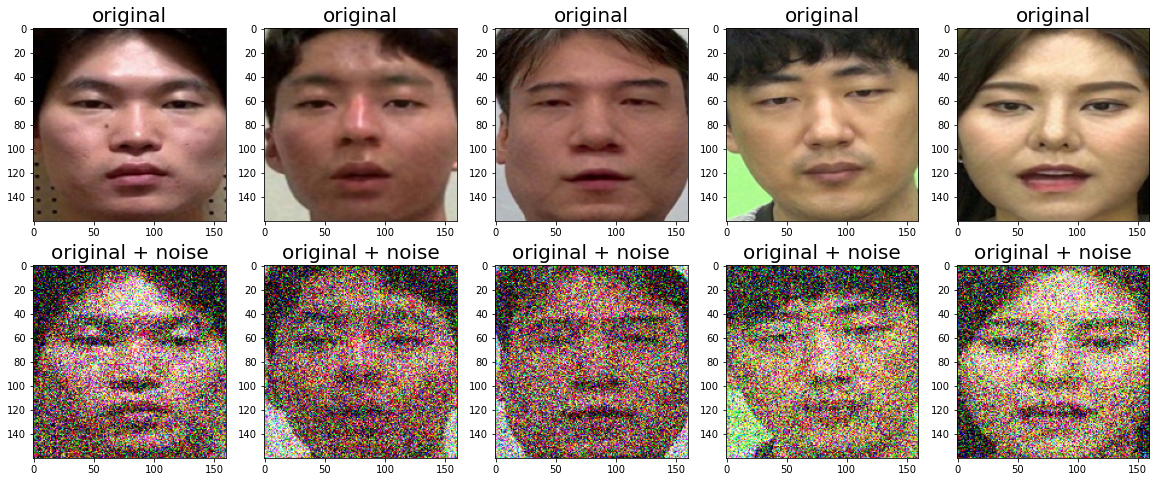

In [4]:
with tf.device('/device:GPU:0'): 
    x_train, x_test = train_test_split(img_data, test_size=0.2)
    print(x_train.shape)
    print(x_test.shape)

    noise_factor = 0.4
    x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
    x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)


    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 5
plt.figure(figsize=(20, 8))
# plt.imshow()
for i in range(n):
    ax = plt.subplot(2, n, i + 1) 
    plt.title("original", size=20) 
    plt.imshow(tf.squeeze(x_test[i])) 
    # plt.gray() 
    bx = plt.subplot(2, n, n+ i + 1) 
    plt.title("original + noise", size=20) 
    plt.imshow(tf.squeeze(x_test_noisy[i])) 
plt.show()

In [17]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model):
    def __init__(self):
        super(NoiseReducer, self).__init__() 

        self.encoder = tf.keras.Sequential([ 
        Input(shape=(160, 160, 3)), 
        Conv2D(16, (3,3), activation='relu', padding='same', strides=2), 
        Conv2D(8, (3,3), activation='relu', padding='same', strides=2)]) 
        
        self.decoder = tf.keras.Sequential([ 
        Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), 
        Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), 
        Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) 
  
    def call(self, x): 
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded) 
        return decoded

In [18]:
autoencoder = NoiseReducer()

In [19]:

autoencoder.compile(optimizer='adam', loss='mse')

In [20]:
with tf.device('/device:GPU:0'):   
    autoencoder.fit(x_train_noisy, 
                    x_train, 
                    epochs=10, 
                    shuffle=True, 
                    validation_data=(x_test_noisy, x_test))

Epoch 1/10
103/103 [==============================] - 5s 47ms/step - loss: 0.0384 - val_loss: 0.0239
Epoch 2/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0174 - val_loss: 0.0132
Epoch 3/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 4/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 5/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 6/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 7/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 8/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 9/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 10/10
103/103 [==============================] - 5s 44ms/step - loss: 0.0117 - val_lo

In [21]:
encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

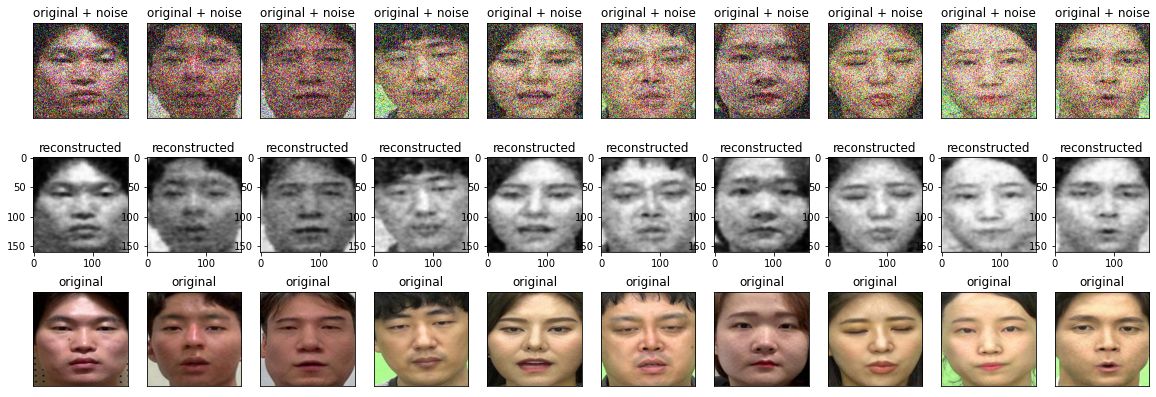

In [22]:

n = 10 
plt.figure(figsize=(20, 7))
# plt.gray()
for i in range(n): 
    # display original + noise 
    bx = plt.subplot(3, n, i + 1) 
    plt.title("original + noise") 
    plt.imshow(tf.squeeze(x_test_noisy[i])) 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
    
    # display reconstruction 
    cx = plt.subplot(3, n, i + n + 1) 
    plt.title("reconstructed") 
    plt.imshow(tf.squeeze(decoded_imgs[i])) 
    bx.get_xaxis().set_visible(False) 
    bx.get_yaxis().set_visible(False) 
    
    # display original 
    ax = plt.subplot(3, n, i + 2*n + 1) 
    plt.title("original") 
    plt.imshow(tf.squeeze(x_test[i])) 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import os.path as pth
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model):
    def __init__(self):

        super(NoiseReducer, self).__init__() 

        self.encoder = tf.keras.Sequential([ 
          Input(shape=(299, 299, 3)), 
          Conv2D(16, (3,3), activation='relu', padding='same', strides=2), 
          Conv2D(8, (3,3), activation='relu', padding='same', strides=2)]) 
    
        self.decoder = tf.keras.Sequential([ 
          Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), 
          Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), 
          Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) 

    def call(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded) 
        return decoded

In [ ]:

autoencoder = NoiseReducer()

In [ ]:

# autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
encoded_imgs=autoencoder.encoder(test_train).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

AttributeError: 'str' object has no attribute '_keras_mask'

In [ ]:
n = 10 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

plt.show()

In [ ]:

path_test = '/home/lab22/data/project_deepfake/test/test_600x600/'                             
df = pd.read_csv('/home/lab10/data/deepfake/sample_submission.csv')


id_list = df.iloc[:,0].values 
print(len(id_list))

id_list=[path_test + num for num in id_list]

image_w = 299 
image_h = 299 
 
test_img_arr = [] 
prediction=[]
batch_size=20                     
steps=len(id_list)//batch_size
print('-'*70)

def score(s):
    if s >= 0.5:
        return 1
    else:
        return 0
    
# print(prediction)
# detector = MTCNN()

for e in range(steps):
    for i, f in enumerate(id_list[e*batch_size:(e+1)*batch_size]): 
        img = Image.open(f) 
        # print(f)
        # img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
        img = img.convert("RGB") 
        img = img.resize((image_w, image_h)) 
        # print(img.shape)
        data = np.asarray(img)
        data = data/255                # rescale
        test_img_arr.append(data)  

    test_img_arr = np.array(test_img_arr)               
    result = model.predict(test_img_arr)
    pred = [score(s) for s in result]
    prediction.append(pred)    
    test_img_arr = []
    print(f'Step {e+1}/ {steps}', end='\n')
print('-'*70)

In [ ]:
# 제출파일 생성

df = pd.DataFrame({'path': df.iloc[:,0].values, 
                   'y': np.array(prediction).ravel()}, 
                    columns = ['path','y']) 

display(df) 

df.to_csv (r'./data/project_deepfake/sample_submisstion_sampling_1114_.csv', index = False, header=True) 